In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cliff import Cliff
import matplotlib.pyplot as plt
from util import Buf, Env, reduce_episodes, get_episode_reward, fill_buffer
from ppo import expected_reward
import typing
import jax, jax.numpy as jnp, jax.random as jr
from tqdm import trange
import pandas as pd

key = jr.key(0)

In [3]:
env = Cliff.full()

In [4]:
class Embedding(typing.NamedTuple):
  num_emb: int
  emb_dim: int

  def __call__(self, params, _key, x):
    return params[x]
  
  def logp(self, params, x, y):
    logits = self(params, ..., x)
    return jax.nn.log_softmax(logits)[y]

  def init(self, key):
    return jr.normal(key, (self.num_emb, self.emb_dim))

In [5]:
class EpsGreedy(typing.NamedTuple):
  model: typing.Any
  num_actions: int
  eps: float = .1

  def __call__(self, params, key, *args):
    key, eps_key = jr.split(key)
    # use cond to run the model only when it's necessary
    return jax.lax.cond(
      jr.uniform(eps_key) >= self.eps,
      # take model's prediction (greedy)
      lambda: self.model(params, key, *args).argmax(axis=-1),
      # select a random action
      lambda: jr.choice(key, self.num_actions),
    )
  
  def logp(self, params, x, y):
    return jnp.log(self.eps / self.num_actions + (1 - self.eps) * jnp.exp(self.model.logp(params, x, y)))

  def init(self, key):
    return self.model.init(key)

In [6]:
action_tab = Embedding(24, 4)
eps_greedy = EpsGreedy(action_tab, 4, eps=.01)

In [7]:
# initialize model parameters
key, model_key = jr.split(key)
params_init = eps_greedy.init(model_key)
params, returns, entropies = params_init, [], []

# create trajectory buffer
buf = Buf(jnp.asarray(20), jnp.asarray(env.max_steps))
buf_state = buf.empty(buf_size=100)

In [8]:
for _ in (pbar := trange(400)):
    # generate trajectories
    buf_state = buf_state.reset() # reset buffer instead of always reallocating
    key, ep_key = jr.split(key)
    buf_state = fill_buffer(ep_key, eps_greedy, params, buf, buf_state, env)

    # compute gradients and update model using gradient ascent
    grads = jax.grad(expected_reward, argnums=1)(eps_greedy, params, buf_state)
    params = jax.tree_util.tree_map(lambda p, g: p + 1e-2 * g, params, grads)

    # bookkeeping
    log_probs = jax.nn.log_softmax(params)
    entropy = (-jnp.mean(log_probs * jnp.exp(log_probs))).item()
    entropies.append(entropy)
    num_eps = buf_state.num_eps.item()
    # compute average return for episodes
    avg_ret = (jnp.sum(get_episode_reward(buf_state)) / buf_state.num_eps).item()
    entropies.append(entropy)
    returns.append(avg_ret)
    pbar.set_description(f"{num_eps=:4d} {avg_ret=:6.01f} {entropy=:6.03f}")

  0%|          | 0/400 [00:00<?, ?it/s]

num_eps=   7 avg_ret=  38.0 entropy= 0.122: 100%|██████████| 400/400 [00:24<00:00, 16.45it/s]


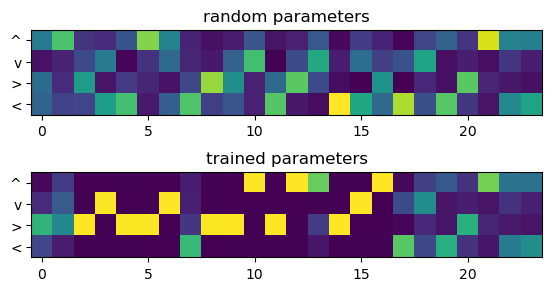

In [9]:
plt.figure(figsize=(8,3))
plt.subplot(2,1,1)
plt.title("random parameters")
plt.yticks(range(4), [*env.ACTION2CHAR.values()])
plt.imshow(jax.nn.softmax(params_init).T)
plt.subplot(2,1,2)
plt.title("trained parameters")
plt.yticks(range(4), [*env.ACTION2CHAR.values()])
plt.imshow(jax.nn.softmax(params).T)
plt.tight_layout();

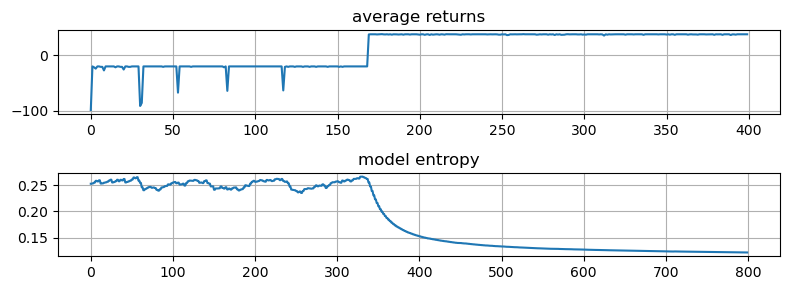

In [10]:
plt.figure(figsize=(8,3))
plt.subplot(2,1,1)
pd.Series(returns).plot.line(ax=plt.gca(), title="average returns", grid=True)
plt.subplot(2,1,2)
pd.Series(entropies).plot.line(ax=plt.gca(), title="model entropy", grid=True)
plt.tight_layout();